In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from mmctools.wrf import preprocessing as wps
import os
import glob
import numpy as np
from netCDF4 import Dataset
from wrf import ll_to_xy
import matplotlib.pyplot as plt

# User Settings:

In [3]:
import sys
sys.path.append('/glade/u/home/hawbecke/Code/Python/publications/')
from Chesapeake.CBB_case_dict import case_dict
cases = list(case_dict.keys())
cases = cases[3:]

In [4]:
sst_datasets = { 'orig' : {'name':'DEFLT'},
                'G1SST' : {'name':'G1SST'}, 
                  'MUR' : {'name':'MUR1K'}, 
                'MODIS' : {'name':'MODIS'}, 
                 'OSPO' : {'name':'OSPOG'}, 
                'OSTIA' : {'name':'OSTIA'}, 
                 'NAVO' : {'name':'NAVOK'}, 
                  'CMC' : {'name':'CMC01'}, 
                 'NCEI' : {'name':'NCEIA'}, 
                 #'FILL' : {'name':'SFILL'},
               }

case_vars_dict = {     
                   'SST' : list(sst_datasets.keys()),
                  'FILL' : ['NOFL','FILL'],
              'SST_SKIN' : ['NOSK','SKNT'],
}

In [5]:
wrf_exe_location = '/glade/work/hawbecke/Models/WRF/WRFvMMC/mmc_develop/WRF/run/'
wps_exe_location = '/glade/work/hawbecke/Models/WRF/WRFvMMC/WPS/'
#wps_exe_location = '/glade/work/hawbecke/Models/WRF/WRFv3.9.1/WPS/'

icbc_type = 'ERAI'  # ERAI, ERA5, FNL
icbc_directory = '/glade/scratch/hawbecke/WRF/ICBC/'

# Case specifics - 60 hour runs for 6 days, 2 day intervals
case_start  = '2019-07-15 18:00:00'
case_end    = '2019-07-29 18:00:00'
case_delta  = '2d'
case_length = '60h'

# Submission script info
submission_dict = {
            'account_key' : 'nsap0003',
         'walltime_hours' : {'wrf':6,'wps':1,'real':1},
             'user_email' : 'hawbecke@ucar.edu',
                  'nodes' : {'wrf':5,'wps':1,'real':5},
                   }

setup_dict = {
             'start_date' : case_start,
               'end_date' : case_end,
              'icbc_type' : icbc_type,
                'max_dom' : 3,
                    'dxy' : 27000,
              'time_step' : 135,
            'max_ts_locs' : 30,
           'max_ts_level' : 19,
        'input_from_file' : [True,True,True],
      'parent_grid_ratio' : [1,3,3],
 'parent_time_step_ratio' : [1,3,5],
         'i_parent_start' : [1, 57, 43],
         'j_parent_start' : [1, 44, 33,],
                     'nx' : [154, 154, 202],
                     'ny' : [133, 133, 202],
                 'e_vert' : 60,
                  'dzbot' : 20.0,
            'dzstretch_s' : 1.1,
                'ref_lat' : 39.00000,
                'ref_lon' : -78.00000,
               'truelat1' : 39.00000,
               'truelat2' : 39.00000,
              'stand_lon' : -78.00000,
          'geog_data_res' : '30s+topobath_30s',
         'geog_data_path' : '/glade/work/hawbecke/geog/',
       'history_interval' : [360,360,60],
       'restart_interval' : 720,
       'auxinput4_inname' : 'wrflowinp_d<domain>',
     'auxinput4_interval' : 360,
      'io_form_auxinput4' : 2,
      'iofields_filename' : 'myoutfields.txt',  
'ignore_iofields_warning' : True,
            'debug_level' : 0,
        'p_top_requested' : 10000,
               'feedback' : 0,
          'smooth_option' : 0,
             'mp_physics' : 6,
      'sf_sfclay_physics' : 1,
     'sf_surface_physics' : 2,
         'bl_pbl_physics' : 1,
             'cu_physics' : [1,1,0],
                 'icloud' : 1,
             'hybrid_opt' : 0,
            'use_theta_m' : 1,
                  'smdiv' : 0.1,
                'nproc_x' : 15,
                'nproc_y' : 12,
#        'shalwater_rough' : 0,
             'sst_update' : 1,
               'sst_skin' : 0,
       'sf_urban_physics' : [0],
       'sf_ocean_physics' : 0,
              'w_damping' : 1,
#      'diff_6th_slopeopt' : [0],
          }

In [6]:
tslist_f = '/glade/work/hawbecke/ATEC/Chesapeake/onshore_tslist'
tslist = open(tslist_f,'r')
tslist.readline()
tslist.readline()
tslist.readline()

twr_lat = []
twr_lon = []
twr_names = []
twr_abbreviation = []
for line in tslist:
    line = line.split()
    twr_names.append(str(line[0]))
    twr_abbreviation.append(str(line[1]))
    twr_lat.append(float(line[2]))
    twr_lon.append(float(line[3]))
    
tslist.close()
print(twr_lon)
print(twr_lat)
print(twr_names)
print(twr_abbreviation)

[-76.17, -76.684, -77.035, -76.611, -77.447, -76.417, -76.48, -76.417, -76.429]
[39.472, 39.173, 38.847, 39.281, 38.935, 39.333, 38.99, 38.3, 38.142]
['APG', 'BWI', 'DCA', 'DMH', 'IAD', 'MTN', 'NAK', 'NHK', 'NUI']
['APG', 'BWI', 'DCA', 'DMH', 'IAD', 'MTN', 'NAK', 'NHK', 'NUI']


# Add buoy locations to tslist:

In [7]:
buoy_loc_dict = {'ANN': {'lat': 38.963, 'lon': -76.448},
                 'BIS': {'lat': 38.22, 'lon': -76.039},
                 'CAM': {'lat': 38.574, 'lon': -76.069},
                 'DEB': {'lat': 38.457, 'lon': -74.702},
                 'FLG': {'lat': 36.998, 'lon': -76.087},
                 'FLN': {'lat': 36.9982, 'lon': -76.08704},
                 'GOO': {'lat': 38.556, 'lon': -76.415},
                 'GRF': {'lat': 38.55624, 'lon': -76.41450999999999},
                 'JTN': {'lat': 37.21137, 'lon': -76.78677},
                 'LWT': {'lat': 37.995, 'lon': -76.465},
                 'PMC': {'lat': 38.03345, 'lon': -76.33753},
                 'SLM': {'lat': 38.321, 'lon': -76.452},
                 'SRP': {'lat': 37.56732, 'lon': -76.26213},
                 'TBL': {'lat': 37.026, 'lon': -76.151},
                 'THP': {'lat': 38.899, 'lon': -76.436},
                 'VAB': {'lat': 36.601, 'lon': -74.834},
                 'YKP': {'lat': 37.20069, 'lon': -76.26611},
                 'YKS': {'lat': 37.201, 'lon': -76.266}}

### Need to make sure all stations are on water cells:

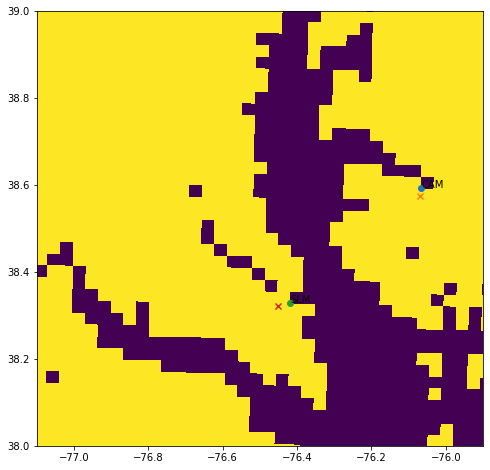

In [8]:
met_file = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/orig/met_em.d03.2019-08-01_06:00:00.nc'
met_ds = Dataset(met_file,'r')

landmask = met_ds['LANDMASK'][0,:,:]
wrf_lat = met_ds['XLAT_M'][0,:,:]
wrf_lon = met_ds['XLONG_M'][0,:,:]

plt.figure(figsize=(8,8))
plt.pcolormesh(wrf_lon,wrf_lat,landmask)
for buoy in buoy_loc_dict:
    buoy_loc = ll_to_xy(met_ds,buoy_loc_dict[buoy]['lat'],buoy_loc_dict[buoy]['lon'])
    if landmask[buoy_loc[1],buoy_loc[0]] != 0.0:
        if buoy == 'SLM':
            buoy_loc[0] += 1
        if buoy == 'CAM':
            buoy_loc[1] += 1
        plt.scatter(wrf_lon[buoy_loc[1],buoy_loc[0]],wrf_lat[buoy_loc[1],buoy_loc[0]])
        plt.scatter(buoy_loc_dict[buoy]['lon'],buoy_loc_dict[buoy]['lat'],marker='x')
        plt.text(wrf_lon[buoy_loc[1],buoy_loc[0]],wrf_lat[buoy_loc[1],buoy_loc[0]],buoy)
        
        buoy_loc_dict[buoy]['lat'] = wrf_lat[buoy_loc[1],buoy_loc[0]]
        buoy_loc_dict[buoy]['lon'] = wrf_lon[buoy_loc[1],buoy_loc[0]]
        

plt.ylim(38,39)
plt.xlim(-77.1,-75.9)
plt.show()


### Add buoys to twr lists:

In [9]:
for buoy in buoy_loc_dict:
    twr_lon.append(buoy_loc_dict[buoy]['lon'])
    twr_lat.append(buoy_loc_dict[buoy]['lat'])
    twr_names.append(buoy)
    twr_abbreviation.append(buoy)
    
    
print(twr_lon)
print(twr_lat)
print(twr_names)
print(twr_abbreviation)

[-76.17, -76.684, -77.035, -76.611, -77.447, -76.417, -76.48, -76.417, -76.429, -76.448, -76.039, -76.06653, -74.702, -76.087, -76.08704, -76.415, -76.41450999999999, -76.78677, -76.465, -76.33753, -76.417725, -76.26213, -76.151, -76.436, -74.834, -76.26611, -76.266]
[39.472, 39.173, 38.847, 39.281, 38.935, 39.333, 38.99, 38.3, 38.142, 38.963, 38.22, 38.59268, 38.457, 36.998, 36.9982, 38.556, 38.55624, 37.21137, 37.995, 38.03345, 38.328117, 37.56732, 37.026, 38.899, 36.601, 37.20069, 37.201]
['APG', 'BWI', 'DCA', 'DMH', 'IAD', 'MTN', 'NAK', 'NHK', 'NUI', 'ANN', 'BIS', 'CAM', 'DEB', 'FLG', 'FLN', 'GOO', 'GRF', 'JTN', 'LWT', 'PMC', 'SLM', 'SRP', 'TBL', 'THP', 'VAB', 'YKP', 'YKS']
['APG', 'BWI', 'DCA', 'DMH', 'IAD', 'MTN', 'NAK', 'NHK', 'NUI', 'ANN', 'BIS', 'CAM', 'DEB', 'FLG', 'FLN', 'GOO', 'GRF', 'JTN', 'LWT', 'PMC', 'SLM', 'SRP', 'TBL', 'THP', 'VAB', 'YKP', 'YKS']


# Setup myoutfields.txt files:

In [10]:
vars_to_remove = ['EDMF_A','EDMF_QC','EDMF_QT','EDMF_ENT','EDMF_W','EDMF_THL','QVAPOR','SH20',
                   'F_ICE_PHY','F_RAIN_PHY','F_RIMEF_PHY','QCLOUD','QRAIN','QSNOW','QHAIL','QGRAUP','QVAPOR',
                  'SMCREL','SHDMAX','SHDMIN','SNOALB','SEAICE','XICEM','SFROFF',
                  'UDROFF','IVGTYP','ACSNOM','SNOW','SNOWNC','SNOWH','CANWAT','COSZEN','LAI','TSLB',
                  'GLW','TMN','SNOWC','SR','QICE','QNICE','QNSNOW','QNRAIN','QNGRAUPEL',
                  'ACLWDNB','ACLWDNBC','ACLWDNT','ACLWDNTC','ACLWUPB','ACLWUPBC','ACLWUPT','ACLWUPTC',
                  'ACSWDNB','ACSWDNBC','ACSWDNT','ACSWDNTC','ACSWUPB','ACSWUPBC','ACSWUPT','ACSWUPTC',
                  'AFWA_RAIN','ALBBCK','ALBEDO','E','EMISS','NEST_POS','LAKEMASK',
                  'MAPFAC_M','MAPFAC_U','MAPFAC_V','MAPFAC_MX','MAPFAC_MY','MAPFAC_UX','MAPFAC_UY','MAPFAC_VX','MF_VX_INV','MAPFAC_VY','SINALPHA',
                  'I_ACLWDNB','I_ACLWDNBC','I_ACLWDNT','I_ACLWDNTC','I_ACLWUPB','I_ACLWUPBC','I_ACLWUPT','I_ACLWUPTC',
                  'I_ACSWDNB','I_ACSWDNBC','I_ACSWDNT','I_ACSWDNTC','I_ACSWUPB','I_ACSWUPBC','I_ACSWUPT','I_ACSWUPTC',
                  'GRAUPELNC','HAILNC','NOAHRES','NUPDRAFT','OLR','XICEM','ZS','DZS',
                  'VAR_SSO','RDX','RDY','SMOIS','VAR','ALBBCK','XLAND','EL_PBL',
                  'P_HYD','CWM','RQCBLTEN','RQIBLTEN','RQNIBLTEN','RQVBLTEN','RUBLTEN','RVBLTEN','RTHBLTEN',
                  'mh1','mh2','mq1','mq2','mq3'
                  ]

vars_to_add = ['ZNT','Z0','SST','SSTSK']

In [11]:
io_fields_meso = {'remove': 
                 {0 : ['EDMF_A','EDMF_QC','EDMF_QT','EDMF_ENT','EDMF_W','EDMF_THL','QVAPOR','SH20',
                   'F_ICE_PHY','F_RAIN_PHY','F_RIMEF_PHY','QCLOUD','QRAIN','QSNOW','QHAIL','QGRAUP','QVAPOR',
                  'SMCREL','SHDMAX','SHDMIN','SNOALB','SEAICE','XICEM','SFROFF',
                  'UDROFF','IVGTYP','ACSNOM','SNOW','SNOWNC','SNOWH','CANWAT','COSZEN','LAI','TSLB',
                  'GLW','TMN','SNOWC','SR','QICE','QNICE','QNSNOW','QNRAIN','QNGRAUPEL',
                  'ACLWDNB','ACLWDNBC','ACLWDNT','ACLWDNTC','ACLWUPB','ACLWUPBC','ACLWUPT','ACLWUPTC',
                  'ACSWDNB','ACSWDNBC','ACSWDNT','ACSWDNTC','ACSWUPB','ACSWUPBC','ACSWUPT','ACSWUPTC',
                  'AFWA_RAIN','ALBBCK','ALBEDO','E','EMISS','NEST_POS','LAKEMASK',
                  'MAPFAC_M','MAPFAC_U','MAPFAC_V','MAPFAC_MX','MAPFAC_MY','MAPFAC_UX','MAPFAC_UY','MAPFAC_VX','MF_VX_INV','MAPFAC_VY',
                  'I_ACLWDNB','I_ACLWDNBC','I_ACLWDNT','I_ACLWDNTC','I_ACLWUPB','I_ACLWUPBC','I_ACLWUPT','I_ACLWUPTC','SINALPHA',
                  'I_ACSWDNB','I_ACSWDNBC','I_ACSWDNT','I_ACSWDNTC','I_ACSWUPB','I_ACSWUPBC','I_ACSWUPT','I_ACSWUPTC',
                  'GRAUPELNC','HAILNC','NOAHRES','NUPDRAFT','OLR','XICEM','ZS','DZS',
                  'VAR_SSO','RDX','RDY','SMOIS','VAR','ALBBCK','XLAND','EL_PBL',
                  'P_HYD','CWM','RQCBLTEN','RQIBLTEN','RQNIBLTEN','RQVBLTEN','RUBLTEN','RVBLTEN','RTHBLTEN',
                  'ACHFX','ACLHF','GRDFLX','ACGRDFLX','SMOIS',
                  'SWUPB','SWUPBC','SWDNB','SWDNBC','LWUPB','LWUPBC','LWDNB','LWDNBC',
                  'RU_TEND','RU_TEND_ADV','RU_TEND_PGF','RU_TEND_COR','RU_TEND_CURV','RU_TEND_HDIFF','RU_TEND_PHYS','T_TEND_ADV',
                  'RV_TEND','RV_TEND_ADV','RV_TEND_PGF','RV_TEND_COR','RV_TEND_CURV','RV_TEND_HDIFF','RV_TEND_PHYS',
                  'U_G','V_G','U_G_TEND','V_G_TEND','MUU','MUV','MUT']
                 },
             'add' : {0: ['ZNT','SST','SSTSK','UST','QFX','HFX','LH']}
            }


# Set up run directory:

In [14]:
for sst_dat in case_vars_dict['SST'][-1:]:
    print(sst_dat)

NCEI


In [16]:
full_case_list = []
for sst_dat in case_vars_dict['SST'][-1:]:
    for f_opt in case_vars_dict['FILL'][:]:
        for s_opt in case_vars_dict['SST_SKIN'][:]:
            case_str = '_'.join([sst_datasets[sst_dat]['name'].upper(), f_opt, s_opt])
            full_case_list.append(case_str)
            
            main_directory = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/{}/'.format(case_str)
            sst_met_str = '{}/'.format(sst_dat)
            if sst_dat != 'orig':
                sst_met_str += 'raw/'
                if f_opt == 'FILL':
                    sst_met_str = sst_met_str[:-1] + '-filled/'
            else:
                if f_opt == 'FILL':
                    sst_met_str = 'FILL/raw-filled/'
                    
                
            met_em_base_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/{}/{}'.format(icbc_type,sst_met_str)

            print('{} - met_em: {}'.format(case_str,met_em_base_dir))
            

            case_dates = pd.date_range(case_start,case_end,freq=case_delta)
            cases = []
            if s_opt == 'NOSK':
                setup_dict['sst_skin'] = 0
            else:
                setup_dict['sst_skin'] = 1

        for cc,case in enumerate(case_dates):
            case_str = str(case).split(' ')[0].replace('-','')
            case_str = '{}_{}'.format(icbc_type,case_str)
            cases.append(case_str)
            run_directory = '{}{}/'.format(main_directory,case_str)
            setup_dict['start_date'] = str(case)
            setup_dict['end_date'] = str(case + pd.to_timedelta(case_length))
                wrf_setup = wps.SetupWRF(run_directory=run_directory,
                                         icbc_directory=icbc_directory,
                                         executables_dict={'wrf':wrf_exe_location,'wps':wps_exe_location})
                wrf_setup.SetupNamelist(setup_dict)
                wrf_setup.CreateRunDirectory()
                wrf_setup.write_namelist('wps')
                wrf_setup.write_namelist('input')
                wrf_setup.write_submission_scripts(submission_dict=submission_dict,hpc='cheyenne')
                ###wrf_setup.write_io_fieldnames(vars_to_remove=[vars_to_remove],vars_to_add=[vars_to_add])
                wrf_setup.write_io_fieldnames(io_fields={'myoutfields.txt':io_fields_meso})
                wrf_setup.create_tslist_file(lat=twr_lat,lon=twr_lon,
                                             twr_names=twr_names,
                                             twr_abbr=twr_abbreviation,
                                             preV4p3=True)
                ##wrf_setup.get_icbcs()
                wrf_setup.link_metem_files(met_em_base_dir)

#wrf_setup.create_submitAll_scripts(main_directory,cases,['wps','real','wrf'])

NCEIA_NOFL_NOSK - met_em: /glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NCEI/raw/


/glade/u/home/hawbecke/Code/Python/mmctools/mmctools/wrf/preprocessing.py:2251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if aux_names != []:


NCEIA_NOFL_SKNT - met_em: /glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NCEI/raw/
NCEIA_FILL_NOSK - met_em: /glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NCEI/raw-filled/
NCEIA_FILL_SKNT - met_em: /glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NCEI/raw-filled/


In [13]:
submit_str = 'for value in '
for case in full_case_list:
    submit_str += '{} '.format(case)
print(submit_str)

for value in DEFLT_NOFL_NOSK DEFLT_NOFL_SKNT DEFLT_FILL_NOSK DEFLT_FILL_SKNT G1SST_NOFL_NOSK G1SST_NOFL_SKNT G1SST_FILL_NOSK G1SST_FILL_SKNT MUR1K_NOFL_NOSK MUR1K_NOFL_SKNT MUR1K_FILL_NOSK MUR1K_FILL_SKNT MODIS_NOFL_NOSK MODIS_NOFL_SKNT MODIS_FILL_NOSK MODIS_FILL_SKNT OSPOG_NOFL_NOSK OSPOG_NOFL_SKNT OSPOG_FILL_NOSK OSPOG_FILL_SKNT OSTIA_NOFL_NOSK OSTIA_NOFL_SKNT OSTIA_FILL_NOSK OSTIA_FILL_SKNT NAVOK_NOFL_NOSK NAVOK_NOFL_SKNT NAVOK_FILL_NOSK NAVOK_FILL_SKNT CMC01_NOFL_NOSK CMC01_NOFL_SKNT CMC01_FILL_NOSK CMC01_FILL_SKNT 


In [22]:
f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/'
for sst_dat in case_vars_dict['SST'][1:-1]:
    for filled in ['raw','raw-filled']:
        for dom in [1,2,3]:
            print('d0{}'.format(dom))
            expected_dates = pd.date_range(start=pd.to_datetime('2019-07-15 18:00'),
                                           end=pd.to_datetime('2019-08-01 06:00'),
                                           freq='6h')
            expected_len = len(expected_dates)

            missing_dates = list(expected_dates.copy())

            dom_files = sorted(glob.glob('{}{}/{}/met_em.d0{}*'.format(f_dir,sst_dat,filled,dom)))

            for ff,fname in enumerate(dom_files):
                date = pd.to_datetime(' '.join(fname.split('/')[-1].split('.')[-2].replace('_',' ').split(' ')[-2:]))
                if date in expected_dates:
                    missing_dates.remove(date)
            if missing_dates != []:
                print('missing the following dates')
                print(missing_dates)
            else:
                print('No files missing!')
            print()

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!

d01
No files missing!

d02
No files missing!

d03
No files missing!



In [18]:
sst_dat

'orig'